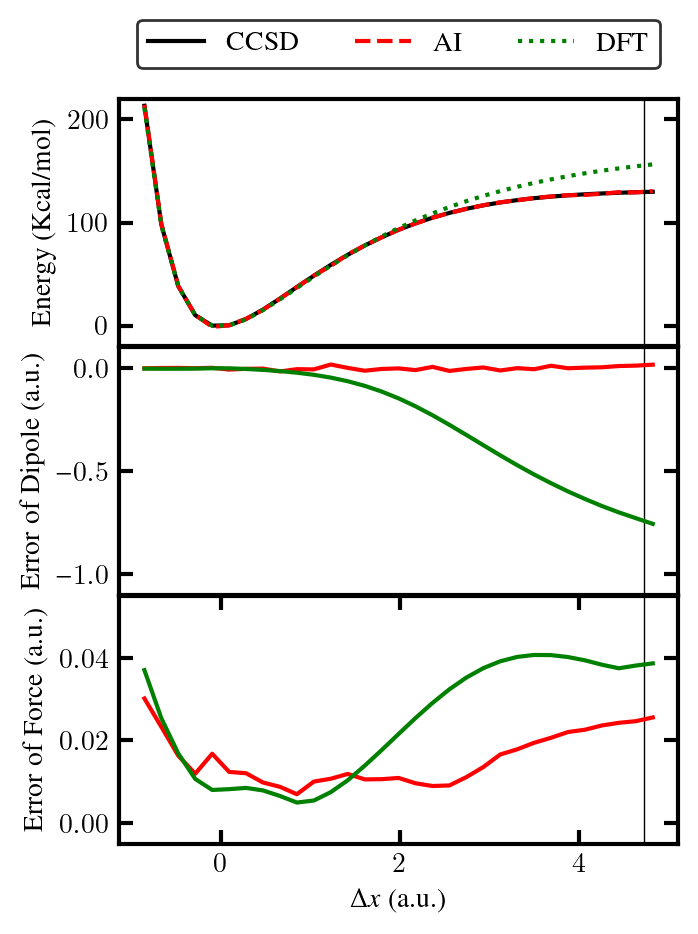

<Figure size 343.056x451.389 with 0 Axes>

In [10]:
from pathlib import Path
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

TRAIN_STR_DICT = [
    "methane",
    # "ethane",
    # "ethylene",
    # "acetylene",
]
EVAL_STR_DICT = [
    # "propane",
    # "propyne",
    # "propylene",
    # "allene",
    # "cyclopropene",
    # "cyclopropane",
    # "butane",
    # "butyne",
    # "isobutane",
    # "butadiene",
    # "pentane",
    # "cyclopentane",
    # "isopentane",
    # "benzene",
]
from matplotlib import rcParams
from matplotlib import rc


rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)
rc("font", family="serif")

rcParams["text.latex.preamble"] = thesis_latex

fontsize = 10.045
sca_size = 2
plt.rc("font", size=fontsize)  # controls default text size
plt.rc("axes", titlesize=fontsize)  # fontsize of the title
plt.rc("axes", labelsize=fontsize)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=fontsize)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=fontsize)  # fontsize of the y tick labels
plt.rc("legend", fontsize=fontsize)  # fontsize of the legend

rcParams["axes.linewidth"] = 1.5
rcParams["lines.linewidth"] = 1.5
rcParams["xtick.major.width"] = 3
rcParams["xtick.minor.size"] = 5
rcParams["xtick.major.size"] = 5
rcParams["ytick.minor.size"] = 5
rcParams["ytick.major.size"] = 5
rcParams["xtick.minor.width"] = 1.5
rcParams["xtick.major.width"] = 1.5
rcParams["ytick.minor.width"] = 1.5
rcParams["ytick.major.width"] = 1.5

plt.rcParams["figure.figsize"] = np.array([0.95, 1.25]) * 520 / 2 / 72


data_dft = pd.read_csv(f"../validate/tz_dft")
number_draw = 0
angtoau = 0.52917721067

for dict_ in [TRAIN_STR_DICT, EVAL_STR_DICT]:
    for i_name in dict_:
        axes_shape = (3, 1)
        f, axes = plt.subplots(*axes_shape)
        if not isinstance(axes, np.ndarray):
            print("Not an array")
            axes = np.array([[axes]])
        elif len(axes.shape) == 1:
            axes = axes.reshape(*axes_shape)

        begin_y = 0.075
        end_y = 0.9
        int_y = 0.00125
        begin_x = 0.175
        end_x = 0.99
        int_x = 0.00125
        end_x += int_x
        end_y += int_y

        shapexy = np.shape(axes)
        inter_x = np.linspace(begin_x, end_x, shapexy[1] + 1)
        inter_y = np.linspace(begin_y, end_y, shapexy[0] + 1)

        delta_x = inter_x[1] - inter_x[0] - int_x
        delta_y = inter_y[1] - inter_y[0] - int_y

        for i in range(shapexy[0]):
            for j in range(shapexy[1]):
                axes[i][j].vlines(
                    2.5 / angtoau,
                    -1000,
                    1000,
                    color="k",
                    linewidth=0.5,
                )
                axes[i][j].set_position(
                    [
                        inter_x[j],
                        inter_y[i],
                        inter_x[j + 1] - inter_x[j] - int_x,
                        inter_y[i + 1] - inter_y[i] - int_y,
                    ]
                )
                axes[i][j].xaxis.set_tick_params(
                    direction="in", which="both", bottom=True, top=True
                )
                axes[i][j].yaxis.set_tick_params(
                    direction="in", which="both", left=True, right=True
                )

        axes = axes[::-1, :]

        # model_number = f"ccdft_2024-09-03-16-44-05_64_4_-1"
        model_number = f"ccdft_2024-09-03-16-44-05_64_4_-1_methane"

        load_name = f"../validate/{model_number}"
        load_path = Path(f"{load_name}")
        if not load_path.exists():
            print(f"File {load_name} not found")
            continue
        data = pd.read_csv(load_path)
        data_tmp = data.loc[data["name"].str.match(i_name)]
        data_eq1 = data_dft.loc[data_dft["name"].str.match(i_name)]
        data_eq = data_eq1.loc[data_eq1["name"].str.contains(f"0_1_0.0000")]

        data_loss_scf_ene = data_tmp["abs_scf_ene"]
        data_loss_dft_ene = data_tmp["abs_dft_ene"]
        data_loss_cc_ene = data_tmp["abs_cc_ene"]
        data_loss_dft_ene = data_loss_dft_ene - np.mean(data_eq["error_dft_ene"])

        name_list = data_tmp["name"].values
        for i in range(len(name_list)):
            name_list[i] = float(name_list[i].split("_")[-1]) / angtoau
        name_list = np.array(name_list)
        cut_off = (name_list < 5) & (name_list > -5)

        axes[0, 0].plot(
            name_list[cut_off],
            (data_loss_cc_ene - np.min(data_loss_cc_ene))[cut_off],
            label=("CCSD"),
            color="k",
        )
        axes[0, 0].plot(
            name_list[cut_off],
            (data_loss_scf_ene - np.min(data_loss_cc_ene))[cut_off],
            "--",
            label=("AI"),
            color="r",
        )
        axes[0, 0].plot(
            name_list[cut_off],
            (data_loss_dft_ene - np.min(data_loss_cc_ene))[cut_off],
            ":",
            label=("DFT"),
            color="g",
        )

        dipole_diff_scf = (
            data_tmp["dipole_x_diff_scf"]
            + data_tmp["dipole_y_diff_scf"]
            + data_tmp["dipole_z_diff_scf"]
        )
        dipole_diff_dft = (
            data_tmp["dipole_x_diff_dft"]
            + data_tmp["dipole_y_diff_dft"]
            + data_tmp["dipole_z_diff_dft"]
        )

        axes[1, 0].plot(
            name_list[cut_off],
            dipole_diff_scf[cut_off],
            label=("Error" + i_name + " AI"),
            color="r",
        )
        axes[1, 0].plot(
            name_list[cut_off],
            dipole_diff_dft[cut_off],
            label=("Error" + i_name + " DFT"),
            color="g",
        )

        error_force_scf = (
            data_tmp["error_force_x_scf"]
            + data_tmp["error_force_y_scf"]
            + data_tmp["error_force_z_scf"]
        )
        error_force_dft = (
            data_tmp["error_force_x_dft"]
            + data_tmp["error_force_y_dft"]
            + data_tmp["error_force_z_dft"]
        )

        axes[2, 0].plot(
            name_list[cut_off],
            error_force_scf[cut_off],
            label=("Error" + i_name + " AI"),
            color="r",
        )
        axes[2, 0].plot(
            name_list[cut_off],
            error_force_dft[cut_off],
            label=("Error" + i_name + " DFT"),
            color="g",
        )

        axes[0, 0].set_xticks([])
        axes[1, 0].set_xticks([])
        axes[0, 0].set_ylim(-20, 220)
        axes[1, 0].set_ylim(-1.1, 0.1)
        axes[2, 0].set_ylim(-0.005,0.055)
        axes[0, 0].set_ylabel("Energy (Kcal/mol)")
        axes[1, 0].set_ylabel("Error of Dipole (a.u.)")
        axes[2, 0].set_ylabel("Error of Force (a.u.)")
        axes[2, 0].set_xlabel(r"$\Delta x$ (a.u.)")
        axes[0, 0].legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.375),
            ncol=3,
            fancybox=True,
            edgecolor="k",
        )
        # for i_col in range(1):
        #     axes[0, i_col].set_ylim(-8, 88)

        plt.savefig(f"../manu/figures/{model_number}.pdf")
        plt.savefig(f"../manu/figures/{model_number}.png")
        plt.show()
        plt.clf()

In [105]:
# ((data_loss_scf_ene - data_loss_cc_ene)[name_list == 0]).values[0]
# name_list

In [30]:
print(f"{111.3774:0.2g}")

1.1e+02


In [5]:
data_tmp = data.loc[data["name"].str.match("pentane")]
data_eq = data_tmp.loc[data_tmp["name"].str.contains(f"0_1_0.0000")]

data_loss_scf_ene = np.abs(data_tmp["error_scf_ene"])
data_loss_dft_ene = data_tmp["error_dft_ene"] - np.mean(
    data_tmp["error_dft_ene"]
)
data_loss_dft_ene = np.abs(data_loss_dft_ene)

In [3]:
data_loss_scf_ene

50     4.681044
51    10.297631
52    15.150055
53    17.307086
54    17.074415
55    17.073513
56    17.304690
57    15.150457
58    10.292622
59     4.694251
Name: error_scf_ene, dtype: float64